In [176]:
import os 
import sys
import glob
import pathlib
import pandas as pd
import requests 
import re

# Build the path to the pdb files
file_dir = os.getcwd()
folder_name = file_dir.split('/')[-1]
repo_dir = file_dir.replace(f'/{folder_name}', '')
plot_dir = f'{file_dir}/plots/'
interaction_csv_path = f'{file_dir}/interactions.csv'

In [148]:
def get_peptide_gpcr_structures():
    # Get a list of peptide ligands and their corresponding structures from GPCRdb API
    url = "https://gpcrdb.org/services/ligands/peptides/"
    response = requests.get(url)
    peptides = response.json()

    # Empty list to store the peptide ligands
    peptide_list = []

    for peptide in peptides:
        name = peptide["Peptide name"]
        seq = peptide["Sequence"]
        pdb = peptide["PDB"]
        family = peptide["Family"]
        gpcr_class = peptide["GPCR Class"]
        receptor = peptide["Receptor"]
        if receptor and "human" in receptor:
            peptide_list.append([name, seq, family, gpcr_class, receptor, pdb])

    # Make a dataframe from the list
    return pd.DataFrame(peptide_list, columns=['peptide', 'sequence', 'family', 'class', 'receptor', 'pdb_code'])

def get_interactions_from_gpcrdb(peptide_df):
    # List to store all interactions
    interactions_df = []

    for index, row in peptide_df.iterrows():
        # Get peptide interactions from GPCRdb
        pdb_code = row["pdb_code"]
        ligand = row["peptide"]
        response = requests.get(f'https://gpcrdb.org/services/structure/{pdb_code}/interaction/')
        interactions = response.json()
        keys_to_extract = [
            "pdb_code",
            "ligand_name",
            "amino_acid",
            "sequence_number",
            "interaction_type",
            "display_generic_number"
        ]

        # Get only those interactions that have a generic residue number and the correct ligand name
        interactions = [i for i in interactions if 'display_generic_number' in i.keys() and i["ligand_name"] == ligand]

        # Remove interactions with label "accessible"
        interactions = [i for i in interactions if i["interaction_type"] != "accessible"]

        # Extract data from required keys
        interactions = [[i[key] for key in keys_to_extract] for i in interactions]

        # Append interactions to interactions_df
        interactions_df.extend(interactions)

    interactions_df = pd.DataFrame(interactions_df, columns=keys_to_extract)
    interactions_df["residue"] = interactions_df["amino_acid"] + interactions_df["sequence_number"].astype(str)

    response = requests.get(f'https://gpcrdb.org/services/structure/')
    structures = response.json()
    structures = pd.DataFrame.from_dict(structures)

    interactions_df = pd.merge(interactions_df, structures, on = "pdb_code")
    return interactions_df

def map_gpcrdb_b_to_a(mapping_file_path):
    # Table containing mapping from GPCRdb A to B general residue numbering
    # Source: https://github.com/protwis/gpcrdb_data/blob/master/residue_data/generic_numbers/mapping_gpcrdbb.txt
    gpcrdb_a_to_b_mapping = []

    # Read text file line by line
    with open("mapping_gpcrdbb.txt") as f:
        lines = f.readlines()

    for line in lines:
        line = line.replace("\n", "")
        line = line.split(" ")
        line = [i for i in line if i != ""]
        if len(line) == 2:
            line = [line[0], line[1]]
            gpcrdb_a_to_b_mapping.append(line)

    gpcrdb_a_to_b_mapping = pd.DataFrame(gpcrdb_a_to_b_mapping)
    gpcrdb_a_to_b_mapping.columns = ["gpcrdb_a", "gpcrdb_b"]

    # Convert to dictionary 
    return dict(zip(gpcrdb_a_to_b_mapping["gpcrdb_b"], gpcrdb_a_to_b_mapping["gpcrdb_a"]))


# Check if output file exists already
if not os.path.exists(interaction_csv_path):
    peptide_df = get_peptide_gpcr_structures()
    interactions_df = get_interactions_from_gpcrdb(peptide_df)
    gpcrdb_b_to_a_mapping = map_gpcrdb_b_to_a(f"{file_dir}/mapping_gpcrdbb.txt")

    # Column to store generic residue number in class A
    interactions_df["generic_residue_number_a"] = ""

    for index, row in interactions_df.iterrows():

        # Parse generic residue number from GPCRdb
        # Remove the string between a dot and x
        # e.g. 3.29x29 -> 3x29
        receptor_grn = row["display_generic_number"]
        receptor_grn = re.sub(r'\.\d+', '', receptor_grn)

        # In case the last part of the GRN is three digits, remove the last digit
        # These residues represent helix bulges at a given position. 
        # For example, 5x501 is a bulge following position 5x50
        if len(receptor_grn.split("x")[-1]) == 3:
            receptor_grn = receptor_grn[:-1]

        # If the class is B1, convert the generic residue number from B to A
        if row["class"] == "Class B1 (Secretin)":
            try: 
                interactions_df.at[index, "generic_residue_number_a"] = gpcrdb_b_to_a_mapping[receptor_grn]
            except:
                print("Failed to map generic residue number ", receptor_grn, " from class B to A")
        else:
            interactions_df.at[index, "generic_residue_number_a"] = receptor_grn

    # Add region labels
    interactions_df["region"] = interactions_df["generic_residue_number_a"].str.split("x").str[0]
    regions = {
        "1" : "TM1",
        "12" : "ICL1",
        "2" : "TM2",
        "23" : "ECL1",
        "3" : "TM3",
        "34" : "ICL2",
        "4" : "TM4",
        "45" : "ECL2",
        "5" : "TM5",
        "56" : "ICL3",
        "6" : "TM6",
        "67" : "ECL3",
        "7" : "TM7"
    }
    interactions_df["region"] = [regions[i] for i in interactions_df["region"]]

    # Sort by protein, ligand_name, and resolution
    interactions_df = interactions_df.sort_values(["protein", "ligand_name", "resolution"])

    # Merge with peptide_df so that we can have peptide sequence in the dataframe
    interactions_df = pd.merge(interactions_df, peptide_df[["sequence", "pdb_code"]], on="pdb_code")

    # Get the best quality pdb for each protein-ligand pair - first based on sequence and then based on ligand name
    pdbs_to_keep = interactions_df.drop_duplicates(["protein", "sequence"], keep="first")["pdb_code"]
    interactions_df = interactions_df[interactions_df["pdb_code"].isin(pdbs_to_keep)]
    interactions_df["ligand_name"] = interactions_df["ligand_name"].str.upper()
    pdbs_to_keep = interactions_df.drop_duplicates(["protein", "ligand_name"], keep="first")["pdb_code"]
    interactions_df = interactions_df[interactions_df["pdb_code"].isin(pdbs_to_keep)]

    # Save to csv
    interactions_df.to_csv(interaction_csv_path, index=False)
else:
    # Read the interactions from the csv file
    interactions_df = pd.read_csv(interaction_csv_path)

In [165]:
# Remove duplicated rows in the subset – make sure that each interacting residue site is only counted once per PDB
interactions_df_subset = interactions_df[["pdb_code", "protein", "ligand_name", "class", "sequence_number", "display_generic_number", "generic_residue_number_a", "region"]].copy()
interactions_df_subset = interactions_df_subset.drop_duplicates()

# Count frequency table of generic residue numbers
grn_frequencies = interactions_df_subset["generic_residue_number_a"].value_counts()
grn_frequencies = pd.DataFrame(grn_frequencies)
grn_frequencies.columns = ["count"]
grn_frequencies["percentage"] = grn_frequencies["count"] / len(interactions_df["pdb_code"].unique()) * 100
grn_frequencies.to_csv(f'{file_dir}/grn_frequencies.csv')

In [166]:
interactions_df_subset[interactions_df_subset["protein"] == "ackr3_human"]



,pdb_code,protein,ligand_name,class,sequence_number,display_generic_number,generic_residue_number_a,region
0,7SK3,ackr3_human,CXCL12&ALPHA;,Class A (Rhodopsin),100,2.60x60,2x60,TM2
2,7SK3,ackr3_human,CXCL12&ALPHA;,Class A (Rhodopsin),103,2.63x63,2x63,TM2
3,7SK3,ackr3_human,CXCL12&ALPHA;,Class A (Rhodopsin),110,23.50x50,23x50,ECL1
4,7SK3,ackr3_human,CXCL12&ALPHA;,Class A (Rhodopsin),117,3.25x25,3x25,TM3
6,7SK3,ackr3_human,CXCL12&ALPHA;,Class A (Rhodopsin),121,3.29x29,3x29,TM3
7,7SK3,ackr3_human,CXCL12&ALPHA;,Class A (Rhodopsin),124,3.32x32,3x32,TM3
8,7SK3,ackr3_human,CXCL12&ALPHA;,Class A (Rhodopsin),179,4.60x61,4x61,TM4
9,7SK3,ackr3_human,CXCL12&ALPHA;,Class A (Rhodopsin),183,4.64x65,4x65,TM4
10,7SK3,ackr3_human,CXCL12&ALPHA;,Class A (Rhodopsin),196,45.50x50,45x50,ECL2
12,7SK3,ackr3_human,CXCL12&ALPHA;,Class A (Rhodopsin),197,45.51x51,45x51,ECL2


In [167]:
# Get number of interactions per receptor
interactions_df_subset["count"] = 1
interactions_df_subset = interactions_df_subset.groupby(["pdb_code", "protein", "ligand_name", "class"]).sum()
interactions_df_subset = interactions_df_subset.reset_index()
interactions_df_subset = interactions_df_subset[["pdb_code", "protein", "ligand_name", "class", "count"]]
interactions_df_subset = interactions_df_subset.sort_values(by=["count"], ascending=False)

# Sort by protein
interactions_df_subset = interactions_df_subset.sort_values(by=["protein", "count"], ascending=True)

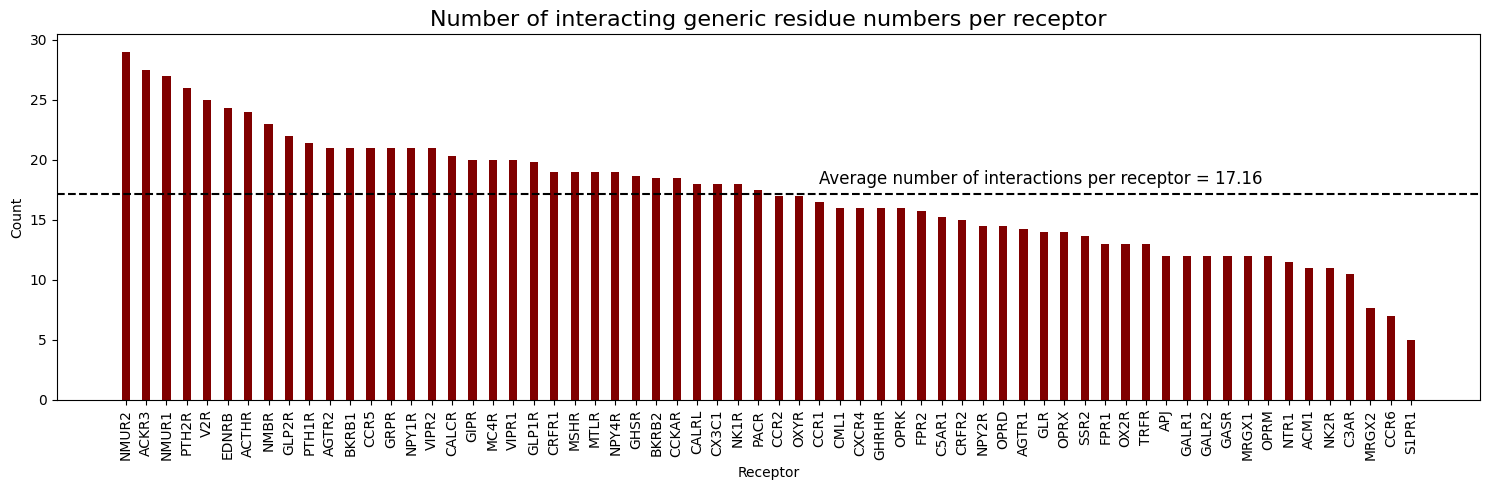

In [184]:
import numpy as np
import matplotlib.pyplot as plt

proteins = list(interactions_df_subset["protein"].unique())
avg_interactions_per_receptor = {}
for protein in proteins:
    average_interactions = interactions_df_subset[interactions_df_subset["protein"] == protein]["count"].mean()
    avg_interactions_per_receptor[protein] = average_interactions

# Sort dictionary by value
avg_interactions_per_receptor = dict(sorted(avg_interactions_per_receptor.items(), key=lambda item: item[1], reverse=True))

x = avg_interactions_per_receptor.keys()
x = [i.split("_")[0].upper() for i in x]
y = avg_interactions_per_receptor.values()
avg_to_plot = np.mean(list(avg_interactions_per_receptor.values()))

# Make barplot
fig = plt.figure(figsize = (15, 5))
plt.bar(x, y, color ='maroon', width = 0.4)
plt.xlabel("Receptor")
plt.ylabel("Count")
plt.title("Number of interacting generic residue numbers per receptor", fontsize = 16)
plt.xticks(rotation=90)

# Add horizontal line
plt.axhline(y=avg_to_plot, color='k', linestyle='--')
plt.text(34, avg_to_plot + 0.8, f'Average number of interactions per receptor = {round(avg_to_plot, 2)}', fontsize=12)
plt.tight_layout()
plt.savefig(plot_dir + "interacting_generic_residue_numbers_per_receptor.png")

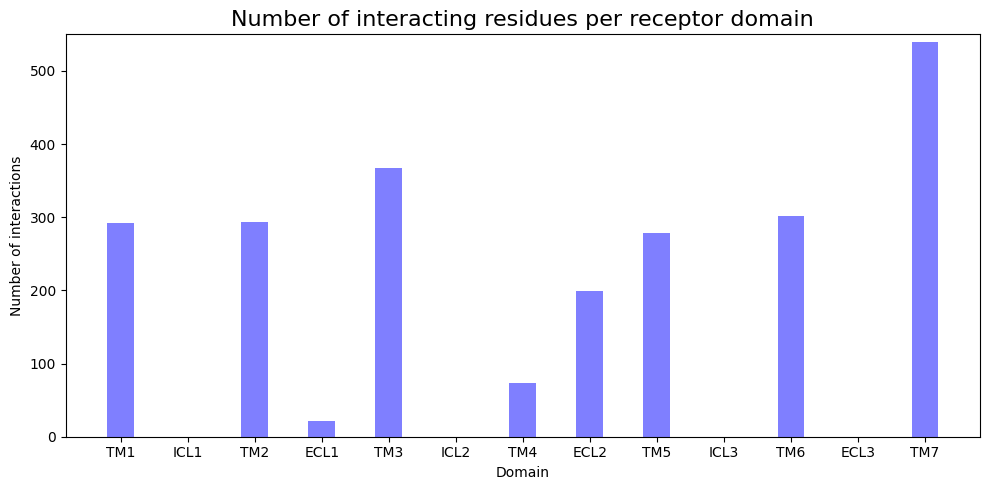

In [191]:
# Get frequency per region
interactions_df_subset = interactions_df[["pdb_code", "protein", "ligand_name", "class", "sequence_number", "display_generic_number", "generic_residue_number_a", "region"]].copy()

# Drop duplicates based on pdb_code and generic_residue_number_a
interactions_df_subset = interactions_df_subset.drop_duplicates(subset=["pdb_code", "generic_residue_number_a"])

region_frequencies = interactions_df_subset["region"].value_counts()
region_frequencies = pd.DataFrame(region_frequencies)
region_frequencies.reset_index(inplace=True)
region_frequencies.columns = ["region","count"]

region_frequencies_dict = {}
for region in list(regions.values()):
    if region in list(region_frequencies["region"]):
        region_frequencies_dict[region] = region_frequencies[region_frequencies["region"] == region]["count"].values[0]
    else: 
        region_frequencies_dict[region] = 0

x = list(region_frequencies_dict.keys())
y = list(region_frequencies_dict.values())

# Make barplot
fig = plt.figure(figsize = (10, 5))
plt.bar(x, y, color ='blue', width = 0.4, alpha = 0.5)
plt.xlabel("Domain")
plt.ylabel("Number of interactions")
plt.title("Number of interacting residues per receptor domain", fontsize = 16)

plt.ylim(0, max(y) + 10)
plt.tight_layout()
plt.savefig(plot_dir + "interacting_residues_per_domain.png")

In [192]:
def plot_piechart(df, column, output_path = "", title = "", font = "Verdana"):

    # Make a pie chart of df column
    x = df[column].value_counts()

    # Make plot bigger
    plt.figure(figsize=(16,7))

    # Change font
    plt.rcParams["font.family"] = font

    # Get total number of values in column
    total = sum(x)

    # Edit labels - include percentage
    labels = [ f"{i} ({round(int(i)/total*100, 2)} %)" if int(i) > 1 else "" for i in x ]

    # Make a pie chart without labels but add legend
    plt.pie(x, labels = labels)
    plt.legend(labels = x.index, loc="center left", bbox_to_anchor=(1.1, 0, 0.5, 1))
    plt.title(title, fontsize = 20, fontweight = 'bold')
    if output_path != "":
        plt.tight_layout()
        plt.savefig(output_path, bbox_inches='tight', dpi = 300) 
    else:
        plt.show()
    plt.close()

plot_piechart(interactions_df, "interaction_type", output_path=f'{plot_dir}interaction_types.png', title = "Interaction types of all interacting residues", font = "Verdana")

In [194]:
grn_frequencies

,count,percentage
7x34,115,84.558824
7x38,108,79.411765
45x52,89,65.441176
3x32,86,63.235294
3x33,82,60.294118
...,...,...
3x24,1,0.735294
1x47,1,0.735294
1x48,1,0.735294
1x27,1,0.735294


In [218]:
# List to store the PDBs that are covered by the generic residue numbers
pdbs_covered = []
pdbs_covered_n = []

# List to store chosen generic residue numbers for the classifier
chosen_grns = []
chosen_grns_per_round = []

# Get the generic residues required to cover all receptor-ligand interactions
for generic_residue_number in grn_frequencies.index:
    grn_subset = interactions_df[interactions_df["generic_residue_number_a"] == generic_residue_number]
    pdbs = grn_subset["pdb_code"].unique()

    # Print pdbs not in pdbs_covered but in pdbs
    pdbs_not_covered = [pdb for pdb in pdbs if pdb not in pdbs_covered]
    if len(pdbs_not_covered) > 0:

        print(f"Generic residue number {generic_residue_number} covers {len(pdbs)} PDBs. PDBs covered: {pdbs_not_covered}")
        pdbs_covered.extend(pdbs)
        pdbs_covered = list(set(pdbs_covered))
        pdbs_covered_n.append(len(pdbs_covered)/len(interactions_df["pdb_code"].unique())*100)

        # Add generic residue number to chosen_grns
        chosen_grns.append(generic_residue_number)
        chosen_grns_per_round.append([chosen_grns.copy()])
        
        if len(pdbs_covered) == len(interactions_df["pdb_code"].unique()):
            break

print("Number of all generic residue numbers: ", len(grn_frequencies.index))
print("Number of generic residue numbers chosen: ", len(chosen_grns))

interactions_chosen_grns = interactions_df[interactions_df["generic_residue_number_a"].isin(chosen_grns)]

plot_piechart(interactions_chosen_grns, "interaction_type", output_path=f"{plot_dir}interaction_types_6_chosen.png", title = "Interaction types of the chosen generic residue numbers", font = "Verdana")


Generic residue number 7x34 covers 115 PDBs. PDBs covered: ['7SK3', '7SK4', '6WJC', '8GY7', '7F6G', '6OS1', '6OS2', '6OS0', '6JOD', '5VBL', '7W0P', '7F2O', '7F6I', '8IA8', '8HK2', '7Y66', '7Y67', '8HK5', '7Y64', '6C1R', '7TYO', '8F0J', '8F0K', '7TYF', '7EZM', '7F8X', '7VL9', '7VLA', '7XA3', '7F1T', '7YKD', '6P9X', '6PB0', '6PB1', '7XBX', '3OE0', '6IGK', '6LRY', '6IGL', '7WVU', '7VFX', '7WVY', '7WVW', '7WVX', '7T6U', '7WQ3', '7XBD', '7WQ4', '7XOX', '7F8W', '7CZ5', '7F9Z', '7W2Z', '7NA7', '7RBT', '6B3J', '7VBH', '7LLY', '7KI1', '5NX2', '7S1M', '6VCB', '7KI0', '7RGP', '7D68', '8FU6', '5YQZ', '7V35', '7F53', '6W25', '7PIV', '7F55', '7PIU', '8DWG', '7S8L', '7F4I', '8IBV', '7P00', '7XWO', '8H0P', '7W53', '7W56', '7W55', '7W57', '7VGX', '7YON', '7YOO', '7X9C', '8JPF', '6OS9', '4RWD', '6PT2', '8F7W', '8F7Q', '8EFQ', '8F7R', '8F7X', '7L1U', '8E3X', '6M1H', '6NBF', '8FLT', '8FLU', '8HAF', '8FLR', '8FLQ', '6FJ3', '8HA0', '7F16', '7XNA', '7T11', '7XAV', '7XW9', '8E3Y', '7VQX']
Generic residue numb

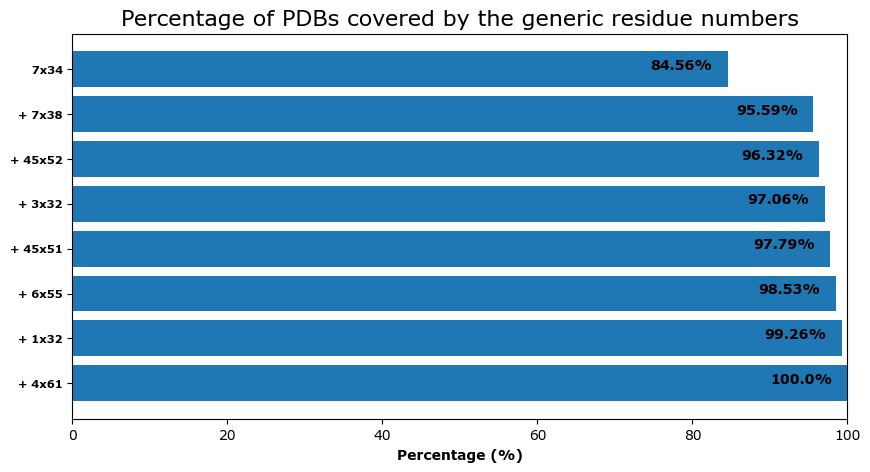

In [219]:
chosen_grns_labels = ["+ " + str(i[0][-1]) for i in chosen_grns_per_round]
chosen_grns_labels[0] = chosen_grns_labels[0].replace("+ ", " ")
chosen_grns_labels

# Cumulative plot of number of PDBs covered by the generic residue numbers
import numpy as np

fig, ax = plt.subplots()
fig.set_figwidth(10) 
fig.set_figheight(5) 

labels = []
labels = chosen_grns_labels
y_pos = np.arange(len(labels))

ax.barh(y_pos, pdbs_covered_n, align='center')
ax.set_yticks(y_pos, labels=labels, size = 8, weight = "bold")
ax.invert_yaxis() 

# Display percentage on top of each bar
for i, v in enumerate(pdbs_covered_n):
    ax.text(v - 10, i, str(round(v, 2)) + "%", color='black', fontweight='bold')

ax.set_xlabel('Percentage (%)', weight = "bold")
ax.set_title("Percentage of PDBs covered by the generic residue numbers", size = 16)
ax.set_xlim(0,100)

plt.savefig("pdbs_covered.png", bbox_inches='tight', dpi = 300)

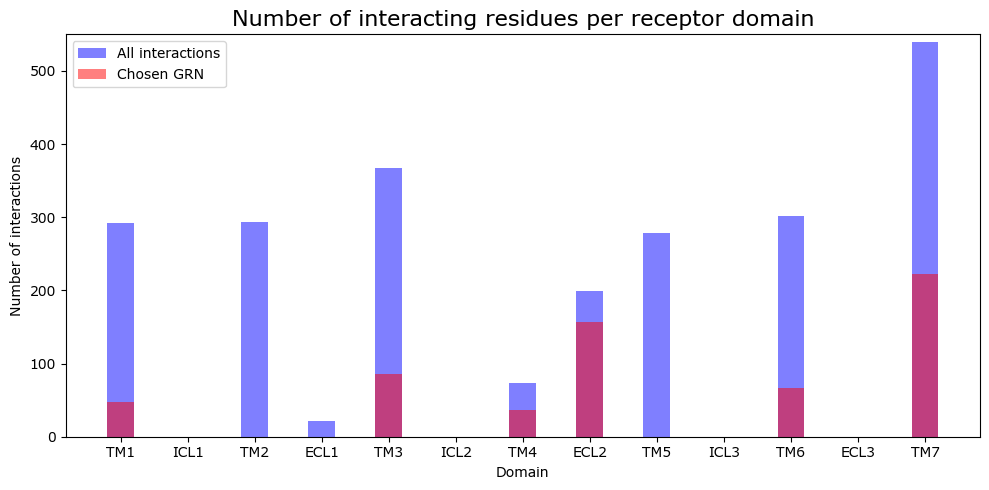

In [220]:
# Get frequency per region
interactions_df_subset = interactions_df[["pdb_code", "protein", "ligand_name", "class", "sequence_number", "display_generic_number", "generic_residue_number_a", "region"]].copy()
interactions_df_subset = interactions_df_subset.drop_duplicates(subset=["pdb_code", "generic_residue_number_a"])

region_frequencies = interactions_df_subset["region"].value_counts()
region_frequencies = pd.DataFrame(region_frequencies)
region_frequencies.reset_index(inplace=True)
region_frequencies.columns = ["region","count"]

region_frequencies_dict = {}
for region in list(regions.values()):
    if region in list(region_frequencies["region"]):
        region_frequencies_dict[region] = region_frequencies[region_frequencies["region"] == region]["count"].values[0]
    else: 
        region_frequencies_dict[region] = 0

x_all = list(region_frequencies_dict.keys())
y_all = list(region_frequencies_dict.values())

# Get frequency per region
interactions_df_subset = interactions_chosen_grns[["pdb_code", "protein", "ligand_name", "class", "sequence_number", "display_generic_number", "generic_residue_number_a", "region"]].copy()
interactions_df_subset = interactions_df_subset.drop_duplicates(subset=["pdb_code", "generic_residue_number_a"])

region_frequencies = interactions_df_subset["region"].value_counts()
region_frequencies = pd.DataFrame(region_frequencies)
region_frequencies.reset_index(inplace=True)
region_frequencies.columns = ["region","count"]

region_frequencies_dict = {}
for region in list(regions.values()):
    if region in list(region_frequencies["region"]):
        region_frequencies_dict[region] = region_frequencies[region_frequencies["region"] == region]["count"].values[0]
    else: 
        region_frequencies_dict[region] = 0

x = list(region_frequencies_dict.keys())
y = list(region_frequencies_dict.values())

# Make barplot
fig = plt.figure(figsize = (10, 5))
plt.bar(x_all, y_all, color ='blue', width = 0.4, label = "All interactions", alpha = 0.5)
plt.bar(x, y, color ='red', width = 0.4, label = "Chosen GRN", alpha = 0.5)

plt.xlabel("Domain")
plt.ylabel("Number of interactions")
plt.title("Number of interacting residues per receptor domain", fontsize = 16)
plt.ylim(0, max(y_all) + 10)

plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(f"{plot_dir}interacting_residues_per_domain_chosen_residues.png")

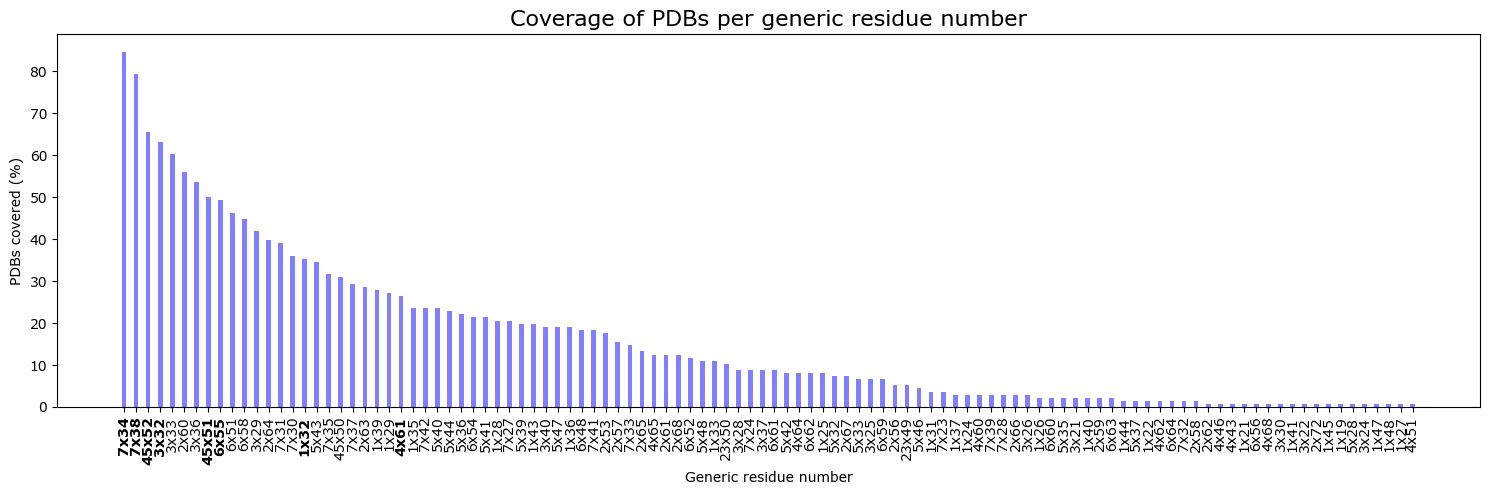

In [222]:
# Make bar plot
fig = plt.figure(figsize=(15, 5))
plt.bar(grn_frequencies.index, grn_frequencies["percentage"], color='blue', width=0.4, alpha=0.5)
plt.xlabel("Generic residue number")
plt.ylabel("PDBs covered (%)")
plt.title("Coverage of PDBs per generic residue number", fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()

# Bold the x-axis labels if they appear in chosen_grns
ax = plt.gca()
labels = ax.get_xticklabels()
for label in labels:
    if label.get_text() in chosen_grns:
        label.set_fontweight('bold')

# Save the plot
plt.savefig(f"{plot_dir}interacting_residues_percentage.png")

# Show the plot
plt.show()

